# Facial Recognition using MLP

## Specify Directories

In [ ]:
SOURCE_DIR = 'Dataset/Original Images/Original Images'
df_DIR = 'Dataset/Dataset.csv'

In [ ]:
import os
print(os.path.isfile(df_DIR))

True


## Import Libraries

In [ ]:
# import libraries
import tensorflow
from tensorflow import keras
# Imports
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

# Confirm mtcnn was installed correctly
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from natsort import natsort_keygen
from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

D:\Uni\Semester 8\AI\env\Lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


## Exploratory Data Analysis

(720, 1280, 3)
(720, 1280)


(-0.5, 1279.5, 719.5, -0.5)

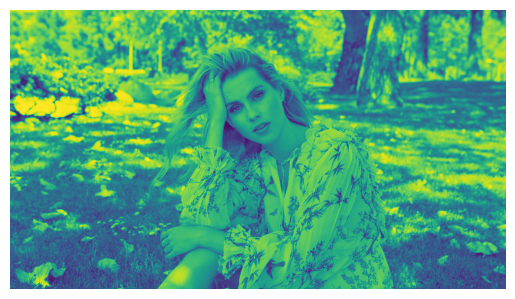

In [ ]:
filename1 = "Dataset/Original Images/Original Images/Claire Holt/Claire Holt_26.jpg"
pixels1 = cv2.imread(filename1)
rgb_pixels1 = np.stack((pixels1), axis=1)
print(pixels1.shape)
gray_image1 = cv2.cvtColor(pixels1, cv2.COLOR_BGR2GRAY)
print(gray_image1.shape)
plt.imshow(gray_image1)
plt.axis('off')

In [ ]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [ ]:
face = face_classifier.detectMultiScale(
    pixels1, scaleFactor=1.01, minNeighbors=3, minSize=(40,40)
)

In [ ]:
for (x, y, w, h) in face:
    cv2.rectangle(pixels1, (x, y), (x + w, y + h), (0, 255, 0), 4)

In [ ]:
img_rgb1 = cv2.cvtColor(pixels1, cv2.COLOR_BGR2RGB)

(-0.5, 1279.5, 719.5, -0.5)

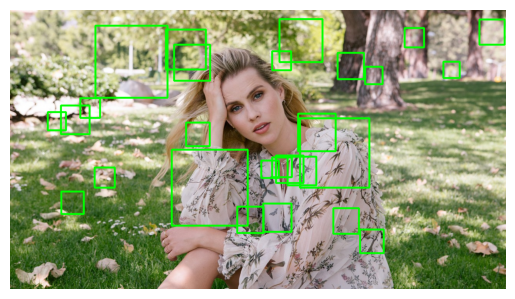

In [ ]:
plt.imshow(img_rgb1)
plt.axis('off')

## Detect Face Functions

In [ ]:
def detect_small_face(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # extract the bounding box from the first face
    # Create the detector, using default weights
    detector = MTCNN(min_face_size=40)
    # detect faces in the image
    results = detector.detect_faces(pixels)
    return results[0]["box"], image

In [ ]:
def detect_face(filename):
    # load image from file
    image = cv2.imread(filename)
    # convert to array
    image2 = np.asarray(image)
    gray_image3 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    face = face_classifier.detectMultiScale(
        gray_image3, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
    )
    if len(face) == 0:
        face = None
    else:
        face = face[0]
    return face, image

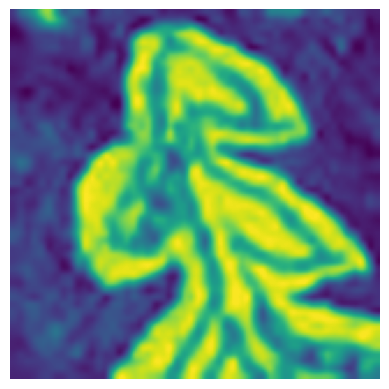

In [ ]:
# extract a single face from a given photograph
def extract_face_from_file(filename, required_size=(160, 160)):
    mamad = extract_face(filename, required_size)
    # print(mamad)
    if(mamad is None):
        print("ex" + filename)
    return mamad

def extract_face(filename, required_size=(160, 160)):
    # detect faces in the image
    results, img = detect_face(filename)
     # Check if any faces are detected
    if results is None:
        results, img = detect_small_face(filename)
    # extract the bounding box from the first face
    x1, y1, width, height = results
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    img = np.asarray(img)
    # extract the face
    face = img[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    return gray_face


# Create the detector, using default weights
# detector = MTCNN(min_face_size=30)

filename = "Dataset/Original Images/Original Images/Natalie Portman/Natalie Portman_1.jpg"
# load the photo and extract the face
face_pixels = extract_face_from_file(filename)
plt.axis("off")
plt.imshow(face_pixels)
plt.show()

## Building Dataset

In [ ]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


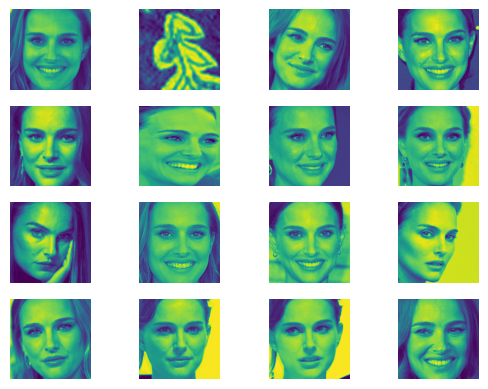

In [ ]:
i = 1
faces = list()
for filename in tqdm(list_files(SOURCE_DIR + "/Natalie Portman", ".jpg")[0:16]):
    # path
    foldername = filename.split('_')[0]
    path = SOURCE_DIR + "/" + foldername + "/" + filename
    # get face
    face = extract_face_from_file(path)
    # plot
    plt.subplot(4, 4, i)
    plt.axis('off')
    faces.append(face)
    plt.imshow(face)
    i += 1
plt.show()

## Setup the Test Train Data

In [ ]:
# list filenames
df = pd.read_csv(df_DIR)

df['class'] = pd.Categorical(df.label).codes
# Sort the DataFrame by the 'id' column using natsorted
df = df.sort_values(
    by="id",
    key=natsort_keygen()
)
df = df.reset_index(drop=True)
df

,id,label,class
0,Akshay Kumar_0.jpg,Akshay Kumar,0
1,Akshay Kumar_1.jpg,Akshay Kumar,0
2,Akshay Kumar_2.jpg,Akshay Kumar,0
3,Akshay Kumar_3.jpg,Akshay Kumar,0
4,Akshay Kumar_4.jpg,Akshay Kumar,0
...,...,...,...
2557,Zac Efron_86.jpg,Zac Efron,30
2558,Zac Efron_87.jpg,Zac Efron,30
2559,Zac Efron_88.jpg,Zac Efron,30
2560,Zac Efron_89.jpg,Zac Efron,30


In [ ]:
# Print classnames
df['label'].unique()

array(['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt',
       'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma',
       'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron',
       'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen',
       'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan',
       'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow',
       'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra',
       'Robert Downey Jr', 'Roger Federer', 'Tom Cruise',
       'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron'], dtype=object)

## Test Train Split (25:75)

In [ ]:
# PER_CLASS = 35 # 50 images (15 test & 35 train)
# NO_CLASSES = 31
# DS_SIZE = df["label"].count()
# TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES / DS_SIZE)

# # list files for each group
# # df.groupby(['subject'])['filename'].apply(list)
y = df['class']
X = df.drop('label',axis=1)

# # subject
X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45, stratify=y)

y_train = y_train.tolist()
y_test = y_test.tolist()

In [ ]:
print(len(y_test))
print(len(y_train))

641
1921


## Extract the Faces

In [ ]:
def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["id"]):
        foldername = filename.split('_')[0]
        path = SOURCE_DIR + "/" + foldername + "/" + filename
        face = extract_face_from_file(path)
        if face is not None:  # Check if a face was successfully extracted
            faces.append(face)
    return np.asarray(faces)

In [ ]:
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

  0%|▎                                                                                 | 2/641 [00:00<03:52,  2.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1921/1921 [13:56<00:00,  2.30it/s]

(641, 160, 160)
(1921, 160, 160)


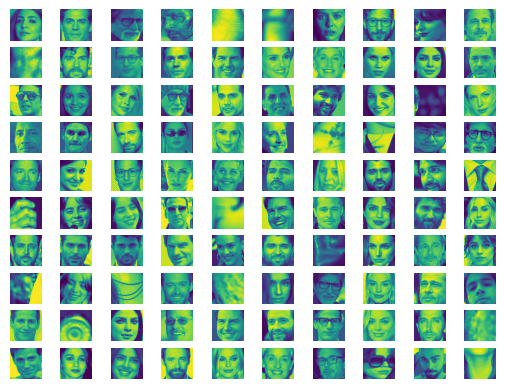

In [ ]:
for i in range (1, 101):
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.imshow(X_test[i])

##Training a Convolutional Neural Network

In [ ]:
# Options

TRAINING_DATA_DIRECTORY = "data/train"
TESTING_DATA_DIRECTORY = "data/test"
NUM_CLASSES = 31
EPOCHS = 25
BATCH_SIZE = 20
NUMBER_OF_TRAINING_IMAGES = 1921
NUMBER_OF_TESTING_IMAGES = 641
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160

###Save the dataset to disk to load into keras

In [ ]:
def save_keras_dataset(setname, dataset, labels, per_class):
    # combine labels and images to generate files
    data = sorted(list(zip(labels, dataset)), key=lambda x: x[0])

    # Save images
    j = 0
    tmp = 0
    for label, gray_img in tqdm(data):
        if label != tmp:
            j = 0
        tmp = label
        j = (j% per_class[label]) + 1
        # Create directory
        directory = f"data/{setname}/class_{label}/"
        if not os.path.exists(directory):
                os.makedirs(directory)
        cv2.imwrite(f"{directory}class_{label}_{j}.png",gray_img)

In [ ]:
# clear directory if it already exists
import shutil
shutil.rmtree(r'data', ignore_errors=True)

# Save datasets
count_test = X_test_info.groupby(['class']).count()
tests_per_class = count_test['id'].values
count_train = X_train_info.groupby(['class']).count()
train_per_class = count_train['id'].values

save_keras_dataset("test", X_test, y_test, tests_per_class)
save_keras_dataset("train", X_train, y_train, train_per_class)

100%|█████████████████████████████████████████████████████████████████████████████| 1921/1921 [00:02<00:00, 923.51it/s]


##Configure data generators with random gaussian noise, zooming and rotation¶

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def data_generator():
    return ImageDataGenerator(
        rescale=1./255,
        # horizontal_flip=True,
#         fill_mode="nearest",
#         zoom_range=0.1,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         rotation_range=10,
        # preprocessing_function=add_noise
    )

In [ ]:
# Setup Data Generators
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False # IMPORTANT: to ensure classes line up with batches
)

Found 1921 images belonging to 31 classes.
Found 641 images belonging to 31 classes.
Found 641 images belonging to 31 classes.


In [ ]:
import keras
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints

# Define a sequential keras model
model = models.Sequential()

# 1st Convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

# 2nd Convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the Convolution
model.add(Flatten())

# Define a dense layer with l2 regularizer to reduce overfitting
model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

# Define a drop layer to reduce overfitting
model.add(MCDropout(rate=0.5))

# Final output layer
model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

D:\Uni\Semester 8\AI\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1056 (Conv2D)                 │ (None, 160, 160, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_528 (MaxPooling2D)     │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1057 (Conv2D)                 │ (None, 78, 78, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_529 (MaxPooling2D)     │ (None, 39, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1058 (Conv2D)                 │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_530 (MaxPooling2D)     │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_176 (Flatten)                │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_616 (Dense)                    │ (None, 512)                 │      21,234,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mc_dropout (MCDropout)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_617 (Dense)                    │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,342,751 (81.42 MB)

 Trainable params: 21,342,751 (81.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

history = model.fit(
    training_generator,
    steps_per_epoch=(NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE ),
    epochs=EPOCHS,
    validation_data=testing_generator,
    shuffle=True,
    validation_steps=(NUMBER_OF_TESTING_IMAGES//BATCH_SIZE),
#     callbacks=[early_stopping]
)

Epoch 1/25


D:\Uni\Semester 8\AI\env\Lib\site-packages\keras\src\backend\tensorflow\nn.py:585: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
D:\Uni\Semester 8\AI\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 775ms/step - accuracy: 0.0440 - loss: 8.6636 - val_accuracy: 0.0484 - val_loss: 4.0328
Epoch 2/25


C:\Users\Yazdan\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0000e+00 - loss: 4.0905 - val_accuracy: 0.0530 - val_loss: 4.0241
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 727ms/step - accuracy: 0.0427 - loss: 3.9093 - val_accuracy: 0.0842 - val_loss: 3.6606
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.0000e+00 - loss: 3.7239 - val_accuracy: 0.0858 - val_loss: 3.6534
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 685ms/step - accuracy: 0.1020 - loss: 3.5853 - val_accuracy: 0.1794 - val_loss: 3.4409
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2000 - loss: 3.4432 - val_accuracy: 0.1295 - val_loss: 3.4480
Epoch 7/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 681ms/step - accuracy: 0.1488 - loss: 3.3668 - val_accuracy: 0.1576 - val_loss: 3.3786
Epoch 8/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.1000 - loss: 3.5452 - val_accuracy: 0.1716 - val_loss: 3.3765
Epoch 9/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 695ms/step - accuracy: 0.1969 - loss: 3.1743 - val_accuracy: 0.205

##CNN Model Evaluation

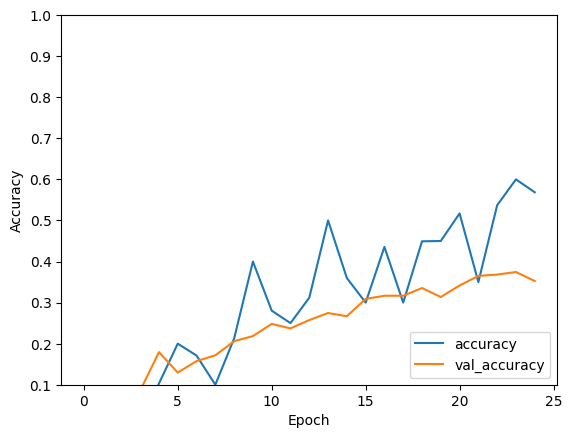

In [ ]:
 plot_folder = "plot"
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

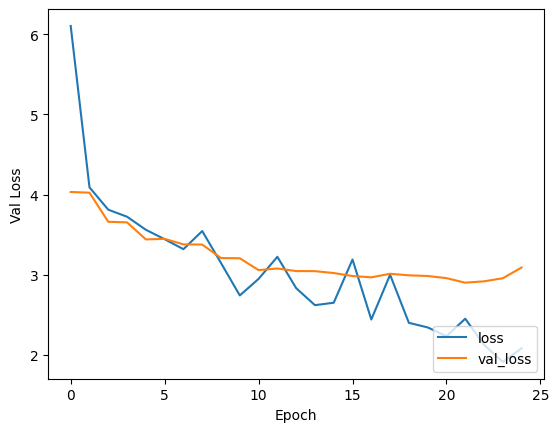

In [ ]:
plot_folder = "plot"
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend(loc='lower right')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(validation_generator.classes, y_pred))
print(validation_generator.classes)
print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.57      0.52      0.55        23
           2       0.38      0.33      0.36        24
           3       0.24      0.25      0.24        20
           4       0.42      0.53      0.47        15
           5       0.36      0.50      0.42        18
           6       0.29      0.42      0.34        19
           7       0.53      0.30      0.38        27
           8       0.29      0.44      0.35        25
           9       0.42      0.46      0.44        28
          10       0.46      0.41      0.43        27
          11       0.00      0.00      0.00         7
          12       0.36      0.25      0.29        20
          13       0.22      0.35      0.27        17
          14       0.44      0.22      0.30        18
          15       0.00      0.00      0.00         8
          16       0.43      0.46      0

D:\Uni\Semester 8\AI\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Uni\Semester 8\AI\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Uni\Semester 8\AI\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Save the model

In [ ]:
MODEL_NAME = "keras_face_recognition.h5"
model_path = "./model"
if not os.path.exists(model_path):
    os.mkdir(model_path)

model.save(os.path.join(model_path, MODEL_NAME))
class_names = training_generator.class_indices
class_names_file_reverse = MODEL_NAME[:-3] + "_class_names_reverse.npy"
class_names_file = MODEL_NAME[:-3] + "_class_names.npy"
np.save(os.path.join(model_path, class_names_file_reverse), class_names)
class_names_reversed = np.load(os.path.join(model_path, class_names_file_reverse), allow_pickle=True).item()
class_names = dict([(value, key) for key, value in class_names_reversed.items()])
np.save(os.path.join(model_path, class_names_file), class_names)

##Sample Testing

In [ ]:
import random
def get_sample_test_image():
    """Chooses a random image from the testing set"""

    # Choose image sample
    expected_class = random.randint(1, NUM_CLASSES)
    random_sample = random.randint(1, 3)

    # Build image path
    image_path = f"data/train/class_{expected_class}/class_{expected_class}_{random_sample}.png"

    # Read the file
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Return the results
    return img, expected_class

In [ ]:
def preprocess_image(img):
    """Ensures the image is the correct shape and normalises the pixels"""

    image = Image.fromarray(img)
    image = image.resize((160,160))
    face_array = np.asarray(image)
    # expands the dimensions
    face_array = face_array.reshape(160,160,1)

    face_array = face_array.astype('float32')
    scaled_image = np.expand_dims(face_array, axis=0)

    return scaled_image

In [ ]:
def prediction(image, debug=True):
    # show the image
    plt.imshow(image)
    plt.show()

    # Process the sample
    input_sample = preprocess_image(img)

    # Prediction
    results = model.predict(input_sample)
    result = np.argmax(results, axis=1)
    index = result[0]

    # Calculate Confidence
    confidence = results[0][index] * 100
    classes = np.load(os.path.join("model", class_names_file), allow_pickle=True).item()
    # Get class name
    if type(classes) is dict:
        for k, v in classes.items():
            if k == index:
                class_name = v
    if debug:
        print(results)
        print("Detected class is {} with {:.2f}% confidence".format(class_name, round(confidence, 2)))

    # Return results
    return class_name, confidence

Expected class: 17


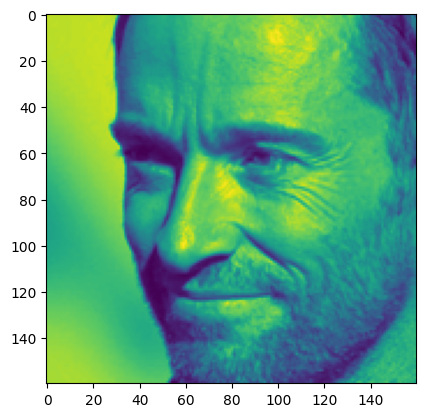

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
Detected class is class_17 with 100.00% confidence


(('class_17', 100.0), 'expected:17')

In [ ]:
# Choose an image
img, expected_class = get_sample_test_image()

print(f"Expected class: {expected_class}")

prediction(img), f"expected:{expected_class}"